# 데모

## 라이브러리 import 및 설정

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [12]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## GloVe 임베딩 로드

http://nlp.stanford.edu/data/glove.6B.zip 를 다운받아 `data_dir`에 압축을 푼다.

In [13]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_author')
data_dir = main_path / 'feed_me'
medium_dir =  main_path / 'medium' 
feature_dir = medium_dir / 'feat' 
val_dir = medium_dir / 'val'
tst_dir = medium_dir / 'tst'
sub_dir =  main_path / 'result' 

dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'
glove_file = data_dir / 'glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [14]:
algo_name = 'lstm'
feature_name = 'glove'
model_name = f'{algo_name}_{feature_name}'

feature_file = medium_dir / 'feat' / f'{feature_name}.csv'
p_val_file = medium_dir / 'val' / f'{model_name}.val.csv'
p_tst_file = medium_dir / 'tst' / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [15]:
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


## 학습데이터 로드

In [16]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [17]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


## Preprocessing

In [18]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [19]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [20]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [21]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=500)
text_ds = tf.data.Dataset.from_tensor_slices(trn).batch(128)
vectorizer.adapt(text_ds)

In [22]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'odin', 'not', 'said']

In [23]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [24]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 18141 words (1859 misses)


In [25]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

## Training

In [26]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [27]:
def get_model():
    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
    x = Bidirectional(LSTM(64))(x)
    preds = Dense(n_class, activation="softmax")(x)
    model = Model(int_sequences_input, preds)
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.01))
    return model

In [28]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    clf = get_model() 
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
86/86 [==============================] - 31s 356ms/step - loss: 1.2734 - val_loss: 1.1079
Epoch 2/10
86/86 [==============================] - 29s 339ms/step - loss: 1.0010 - val_loss: 0.9619
Epoch 3/10
86/86 [==============================] - 29s 338ms/step - loss: 0.8644 - val_loss: 0.8906
Epoch 4/10
86/86 [==============================] - 29s 339ms/step - loss: 0.8085 - val_loss: 0.9103
Epoch 5/10
86/86 [==============================] - 29s 340ms/step - loss: 0.7053 - val_loss: 0.8578
Epoch 6/10
86/86 [==============================] - 29s 340ms/step - loss: 0.6005 - val_loss: 0.8643
Epoch 7/10
86/86 [==============================] - 29s 341ms/step - loss: 0.5299 - val_loss: 0.9212
Epoch 8/10
86/86 [==============================] - 29s 340ms/step - loss: 0.4751 - val_loss: 0.9892
Epoch 00008: early stopping
training model for CV #2
Epoch 1/10
86/86 [==============================] - 31s 356ms/step - loss: 1.2563 - val_loss: 1.0818
Epoch 2/10
86

In [29]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  67.1204%
Log Loss (CV):   0.8635


In [30]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [31]:
clf.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 100)          2000200   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 500, 128)          84480     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 2,184,141
Trainable params: 183,941
Non-trainable params: 2,000,200
______________________________________

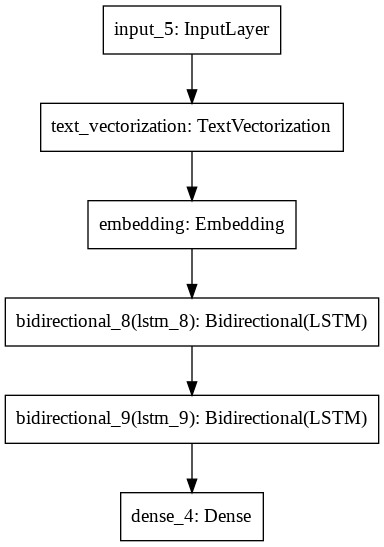

In [32]:
plot_model(clf)

## 제출 파일 생성

In [33]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [34]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0441,0.4452,0.0710,0.4210,0.0187
1,0.3275,0.1724,0.0244,0.0895,0.3862
2,0.8102,0.0315,0.0373,0.0213,0.0997
3,0.0821,0.0171,0.6443,0.0082,0.2482
4,0.7526,0.0612,0.0252,0.0503,0.1106


In [35]:
sub.to_csv(sub_file)